In [1]:
import random
from collections import Counter
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from bs4 import BeautifulSoup
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, RepeatVector, Flatten
from keras.callbacks import EarlyStopping
from math import ceil

# IMPUTION OF NAN VALUES 
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

In [2]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
def plot_main_number_frequency(historical_data):
    """
    Plots the frequency distribution of the main numbers in the historical data.

    Parameters:
        historical_data (pd.DataFrame): DataFrame containing historical lottery data.
    """
    all_main_numbers = [num for draw in historical_data.iloc[:, :-1].values for num in draw]
    main_number_counts = Counter(all_main_numbers)
    main_numbers, counts = zip(*main_number_counts.items())

    plt.figure(figsize=(10, 6))
    plt.bar(main_numbers, counts, align='center', alpha=0.7)
    plt.xlabel('Main Number')
    plt.ylabel('Frequency')
    plt.title('Frequency Distribution of Main Numbers')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_chance_number_frequency(historical_data):
    """
    Plots the frequency distribution of the chance number in the historical data.

    Parameters:
        historical_data (pd.DataFrame): DataFrame containing historical lottery data.
    """
    chance_number_counts = Counter(historical_data["chance"])
    chance_numbers, counts = zip(*chance_number_counts.items())

    plt.figure(figsize=(6, 4))
    plt.bar(chance_numbers, counts, align='center', alpha=0.7)
    plt.xlabel('Chance Number')
    plt.ylabel('Frequency')
    plt.title('Frequency Distribution of Chance Number')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [4]:
def plot_main_number_trends(historical_data):
    """
    Plots the trends of the main numbers over time.

    Parameters:
        historical_data (pd.DataFrame): DataFrame containing historical lottery data.
    """
    df_main_numbers = historical_data.iloc[:, :-1]
    df_main_numbers = df_main_numbers.rename(columns={"num0": "Main 1", "num1": "Main 2", "num2": "Main 3", "num3": "Main 4", "num4": "Main 5"})

    plt.figure(figsize=(12, 6))
    for column in df_main_numbers.columns:
        plt.plot(df_main_numbers.index, df_main_numbers[column], label=column)

    plt.xlabel('Draw Index')
    plt.ylabel('Main Numbers')
    plt.title('Trends of Main Numbers Over Time')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_chance_number_trends(historical_data):
    """
    Plots the trends of the chance number over time.

    Parameters:
        historical_data (pd.DataFrame): DataFrame containing historical lottery data.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(historical_data.index, historical_data["chance"], marker='o', linestyle='-')
    plt.xlabel('Draw Index')
    plt.ylabel('Chance Number')
    plt.title('Trends of Chance Number Over Time')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [5]:
def seasonal_decomposition(data, period):
    """
    Performs seasonal decomposition of the time series data.

    Parameters:
        data (pd.Series): Time series data for decomposition.
        period (int): Seasonality period of the time series.

    Returns:
        decomposition (DecomposeResult): Decomposition result object from statsmodels.
    """
    decomposition = sm.tsa.seasonal_decompose(data, period=period)
    return decomposition

def plot_seasonal_decomposition(data, period, main_number):
    """
    Plots the seasonal decomposition of the time series data.

    Parameters:
        data (pd.Series): Time series data for decomposition.
        period (int): Seasonality period of the time series.
        main_number (str): Identifier for the main number being analyzed.
    """
    decomposition = seasonal_decomposition(data, period=period)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(data.index, data, label='Original Data')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title(f"Seasonal Decomposition - Main Number {main_number}")
    
    plt.subplot(4, 1, 2)
    plt.plot(data.index, decomposition.trend, label='Trend')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Compute 80% of the maximum and minimum trend values
    trend_80_percentile = decomposition.trend.quantile(0.8)
    trend_20_percentile = decomposition.trend.quantile(0.2)
    plt.axhline(trend_80_percentile, color='r', linestyle='--', label='80% Max Trend')
    plt.axhline(trend_20_percentile, color='g', linestyle='--', label='80% Min Trend')
    
    plt.subplot(4, 1, 3)
    plt.plot(data.index, decomposition.seasonal, label='Seasonal')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.subplot(4, 1, 4)
    plt.plot(data.index, decomposition.resid, label='Residuals')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Compute 80% of the maximum and minimum Residuals values
    resid_80_percentile = decomposition.resid.quantile(0.8)
    resid_20_percentile = decomposition.resid.quantile(0.2)
    plt.axhline(resid_80_percentile, color='r', linestyle='--', label='80% Max Trend')
    plt.axhline(resid_20_percentile, color='g', linestyle='--', label='80% Min Trend')
    
    plt.tight_layout()
    plt.show()

def seasonal_decomposition_for_each_main_number(historical_data, period):
    """
    Performs seasonal decomposition for each main number separately.

    Parameters:
        historical_data (pd.DataFrame): DataFrame containing historical lottery data.
        period (int): Seasonality period of the time series.

    Returns:
        None (Plots seasonal decomposition for each main number).
    """
    main_numbers = historical_data.iloc[:, :-1]

    for column in main_numbers.columns:
        plot_seasonal_decomposition(main_numbers[column], period, main_number=column)

In [6]:
def modified_z_score(data):
    """
    Calculate the Modified Z-Score for a given dataset.

    Parameters:
        data (array-like): Input data for outlier detection.

    Returns:
        z_scores (array): Modified Z-Scores for each data point.
    """
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    z_scores = 0.6745 * (data - median) / mad
    return z_scores

def detect_outliers(data, threshold):
    """
    Detect outliers in a dataset using Modified Z-Score Method.

    Parameters:
        data (pd.Series): Input data for outlier detection.
        threshold (float): Threshold for outlier detection.

    Returns:
        outliers (list): List of indices of outlier data points.
    """
    z_scores = modified_z_score(data)
    outliers = np.where(np.abs(z_scores) > threshold)[0]
    return outliers

def count_outliers(data, threshold):
    """
    Count the total number of outliers in each column of the data.

    Parameters:
        data (pd.DataFrame): Input data for outlier detection.
        threshold (float): Threshold for outlier detection.

    Returns:
        outlier_counts (dict): Dictionary containing the number of outliers for each column.
    """
    outlier_counts = {}
    for column in data.columns:
        outliers = detect_outliers(data[column], threshold)
        outlier_counts[column] = len(outliers)
    return outlier_counts

def plot_main_number_trends_with_outliers(historical_data, threshold):
    main_numbers = historical_data.iloc[:, :-1]

    for column in main_numbers.columns:
        plt.figure(figsize=(10, 6))
        plt.plot(historical_data.index, main_numbers[column], label='Trend')
        
        # Detect outliers for the current main number
        outliers = detect_outliers(main_numbers[column], threshold)
        if len(outliers) > 0:
            plt.scatter(historical_data.index[outliers], main_numbers[column].iloc[outliers], color='r', label='Outliers')
        
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.title(f"Trend - Main Number {column}")
        plt.xlabel('Date')
        plt.ylabel('Main Number')
        plt.show()

In [7]:
# Function to calculate moving averages for each main number
def moving_averages(data, window_sizes=[3, 5, 7]):
    for size in window_sizes:
        col_name = f'MovingAvg_{size}'
        data[col_name] = data.iloc[:, :6].rolling(window=size).mean().iloc[:, -1]
    return data

# Function to create lagged features for each main number
def lagged_features(data, lag_sizes=[1, 2, 3]):
    for size in lag_sizes:
        col_name = f'Lagged_{size}'
        data[col_name] = data.iloc[:, :6].shift(size).iloc[:, -1]
    return data

# Function to count the occurrences of each main number
def frequency_count(data):
    for i in range(50):
        col_name = f'Frequency_{i+1}'
        data[col_name] = (data.iloc[:, :6] == i+1).sum(axis=1)
    return data


# Function to calculate statistical measures for each main number
def statistical_measures(data):
    data['Mean'] = data.iloc[:, :6].mean(axis=1)
    data['Std'] = data.iloc[:, :6].std(axis=1)
    data['Variance'] = data.iloc[:, :6].var(axis=1)
    return data


# Function to analyze number pair frequency
def number_pair_frequency(data):
    for i in range(1, 51):
        for j in range(i+1, 51):
            col_name = f'PairFreq_{i}_{j}'
            data[col_name] = ((data.iloc[:, :6] == i) & (data.iloc[:, :6].shift(-1) == j)).sum(axis=1)
    return data


# Function to include the winning numbers from the most recent lottery draws
def recent_winning_numbers(data, num_draws=5):
    for i in range(num_draws):
        col_name = f'RecentDraw_{i+1}'
        data[col_name] = data.iloc[:, :6].shift(-i).iloc[:, -1]
    return data

In [8]:
# Function to compute the digit sum of each main number
def digit_sum(data):
    for i in range(50):
        col_name = f'DigitSum_{i+1}'
        data[col_name] = data.iloc[:, :6].apply(lambda row: sum(int(digit) for digit in row == i+1), axis=1)
    return data

# Function to calculate the number range for each draw
def number_range(data):
    data['NumberRange'] = data.iloc[:, :6].max(axis=1) - data.iloc[:, :6].min(axis=1)
    return data

# Function to count consecutive numbers for each draw
def consecutive_numbers(data):
    data['ConsecutiveNumbers'] = (data.iloc[:, :6].diff(axis=1) == 1).sum(axis=1)
    return data

# Function to calculate number differences for each draw
def number_differences(data):
    for i in range(49):
        col_name = f'NumberDiff_{i+1}_{i+2}'
        data[col_name] = data.iloc[:, i+1] - data.iloc[:, i]
    return data

# Function to create binary features for odd/even numbers
def odd_even_numbers(data):
    for i in range(50):
        col_name = f'Odd_{i+1}'
        data[col_name] = data.iloc[:, i] % 2
    return data

# Function to create binary features for prime numbers
def prime_numbers(data):
    primes = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]
    for prime in primes:
        col_name = f'Prime_{prime}'
        data[col_name] = (data.iloc[:, :6] == prime).any(axis=1)
    return data

# Function to calculate the sum and product of main numbers in each draw
def number_sums_products(data):
    data['NumberSum'] = data.iloc[:, :6].sum(axis=1)
    data['NumberProduct'] = data.iloc[:, :6].prod(axis=1)
    return data


In [9]:
b_removeLastTirage = False

In [10]:
# 1. Fonction de scraping des tirages du loto depuis le site loto.akroweb.fr
def scrap_loto_numbers():
    my_list=[]
    time.sleep(2)
    loto_url = "http://loto.akroweb.fr/loto-historique-tirages/"
    page = requests.get(loto_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    body = soup.find('table')
    tirage_line = body.find_all('tr')
    for value in tirage_line:
        my_dict = {}
        res = value.text.split('\n')
        my_dict['day']=res[2]
        my_dict['month_year']=res[3]

        for i,val in enumerate(res[5:10]):
            my_dict['num'+str(i)]=int(val)
        my_dict['chance']=int(res[10])
        my_list.append(my_dict)


    df=pd.DataFrame(my_list)
    return df

# GET HISTORICAL DATA FROM WEBSITE (webscraping)

In [11]:
# 2. Scraping des tirages actuellement disponibles sur le site
df_tirage = scrap_loto_numbers()
df_tirage[['day', 'month_year', 'num0', 'num1', 'num2', 'num3', 'num4', 'chance']].head()

# 3. Suppression des tirages du super loto, c'est-à-dire ceux qui ne sont pas Lundi, Mercredi, Samedi!
df_tirage = df_tirage[(df_tirage['day'] != 'Mardi') & (df_tirage['day'] != 'Jeudi') & (df_tirage['day'] != 'Vendredi') & (df_tirage['day'] != 'Dimanche')]
df_tirage

# 3. Choix de la date pour la prédiction à effectuer
# --> Mettre en commentaire cette ligne si on veut prédire la date retirée du dataset
# --> Sinon, NE PAS METTRE en commentaire si on veut prédire le prochain tirage.
last_row = len(df_tirage) - 1
if b_removeLastTirage:
    df_tirage.drop(index=df_tirage.index[0], axis=0, inplace=True)
df_tirage

# 1. Inverser le tableau afin de placer le dernier tirage en dernière position puis choix des numéros à traiter
df = df_tirage.iloc[::-1]
month_year_column = df['month_year']
df = df[['num0', 'num1', 'num2', 'num3', 'num4', 'chance']]  # Sélection des numéros à traiter
historical_data = df


,day,month_year,num0,num1,num2,num3,num4,chance
0,Samedi,22 juillet 2023,31,33,36,37,42,3
1,Mercredi,19 juillet 2023,5,11,19,35,39,9
2,Lundi,17 juillet 2023,6,9,20,41,47,9
3,Samedi,15 juillet 2023,7,12,32,42,45,6
4,Mercredi,12 juillet 2023,18,26,27,31,34,8


,day,month_year,num0,num1,num2,num3,num4,chance
0,Samedi,22 juillet 2023,31,33,36,37,42,3
1,Mercredi,19 juillet 2023,5,11,19,35,39,9
2,Lundi,17 juillet 2023,6,9,20,41,47,9
3,Samedi,15 juillet 2023,7,12,32,42,45,6
4,Mercredi,12 juillet 2023,18,26,27,31,34,8
...,...,...,...,...,...,...,...,...
2362,Mercredi,15 octobre 2008,18,20,28,40,49,1
2363,Lundi,13 octobre 2008,10,11,37,41,48,4
2364,Samedi,11 octobre 2008,10,20,22,39,46,4
2365,Mercredi,08 octobre 2008,22,24,32,41,48,1


,day,month_year,num0,num1,num2,num3,num4,chance
0,Samedi,22 juillet 2023,31,33,36,37,42,3
1,Mercredi,19 juillet 2023,5,11,19,35,39,9
2,Lundi,17 juillet 2023,6,9,20,41,47,9
3,Samedi,15 juillet 2023,7,12,32,42,45,6
4,Mercredi,12 juillet 2023,18,26,27,31,34,8
...,...,...,...,...,...,...,...,...
2362,Mercredi,15 octobre 2008,18,20,28,40,49,1
2363,Lundi,13 octobre 2008,10,11,37,41,48,4
2364,Samedi,11 octobre 2008,10,20,22,39,46,4
2365,Mercredi,08 octobre 2008,22,24,32,41,48,1


In [12]:
# 1. Inverser le tableau afin de placer le dernier tirage en dernière position puis choix des numéros à traiter
df = df_tirage.iloc[::-1]
df = df[['num0', 'num1', 'num2', 'num3', 'num4', 'chance']]#sélection des numéros à  traiter
historical_data = df
historical_data_copy = historical_data
historical_data

,num0,num1,num2,num3,num4,chance
2366,19,24,27,33,41,9
2365,22,24,32,41,48,1
2364,10,20,22,39,46,4
2363,10,11,37,41,48,4
2362,18,20,28,40,49,1
...,...,...,...,...,...,...
4,18,26,27,31,34,8
3,7,12,32,42,45,6
2,6,9,20,41,47,9
1,5,11,19,35,39,9


# DATA VISUALIZATION (FREQUENCY, TRENDS, OUTLIERS, SEASONALITY DECOMPOSITION ...

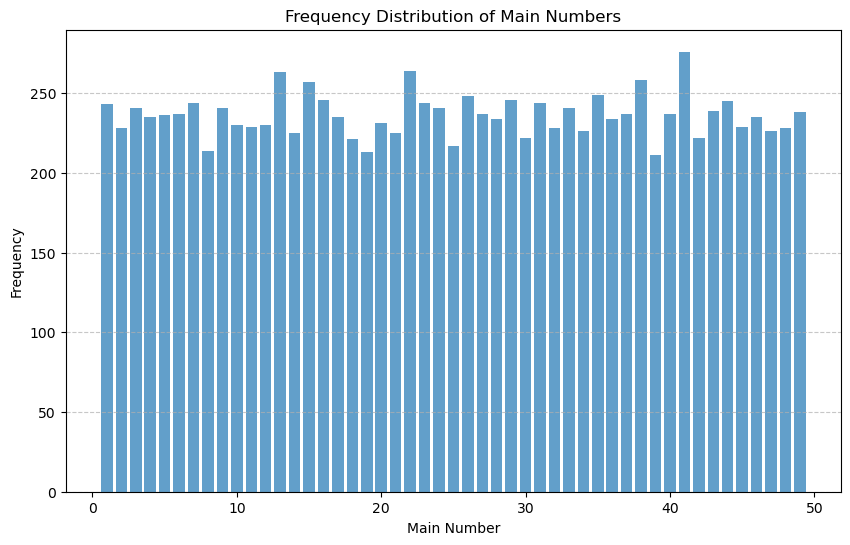

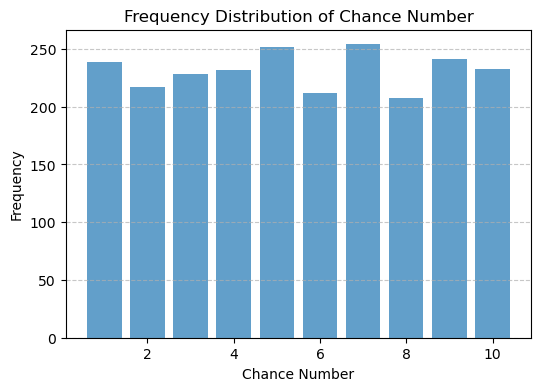

In [13]:
# Data Visualization: Plot frequency distribution of each number
plot_main_number_frequency(historical_data)
plot_chance_number_frequency(historical_data)

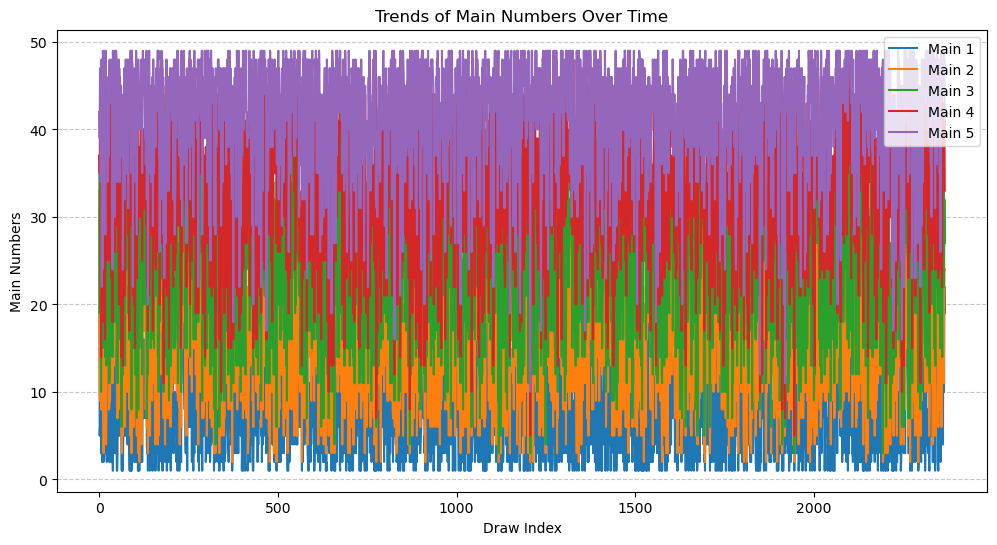

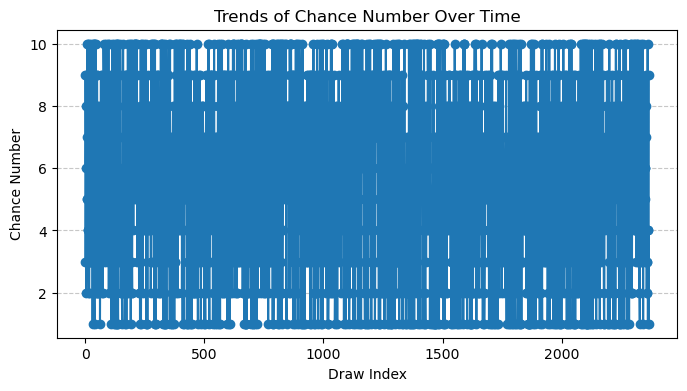

In [14]:
#  Another useful functionality we can add is to visualize the trends of main numbers 
# and the chance number over time. This will help users observe how the frequency 
# of each number changes over different time periods in the historical data.

# Data Visualization: Plot trends of main numbers and chance number over time
plot_main_number_trends(historical_data)
plot_chance_number_trends(historical_data)

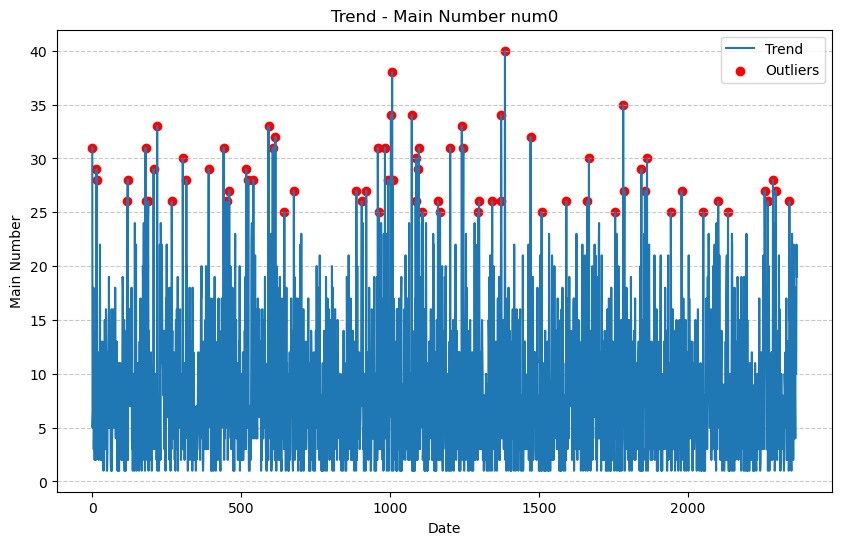

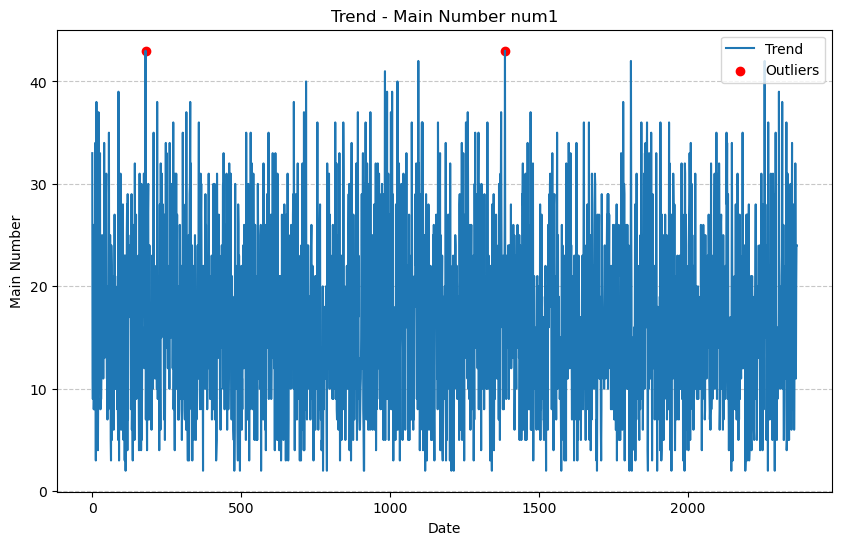

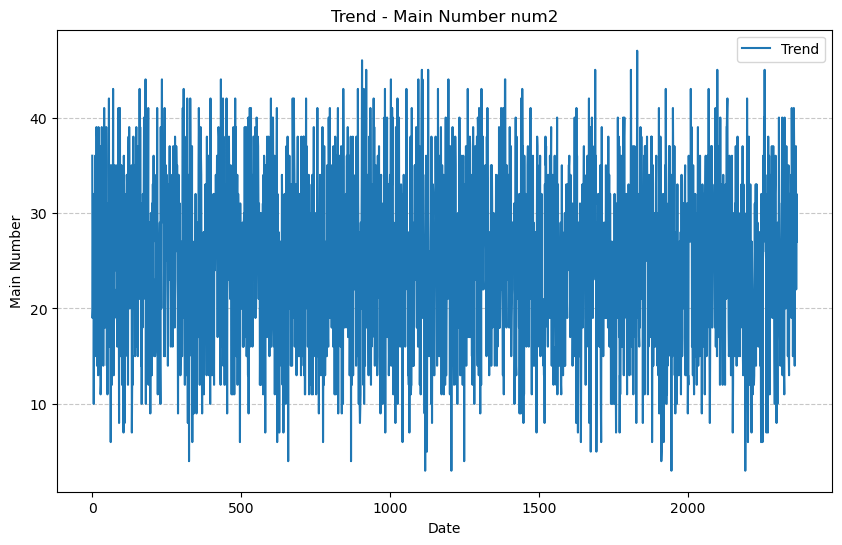

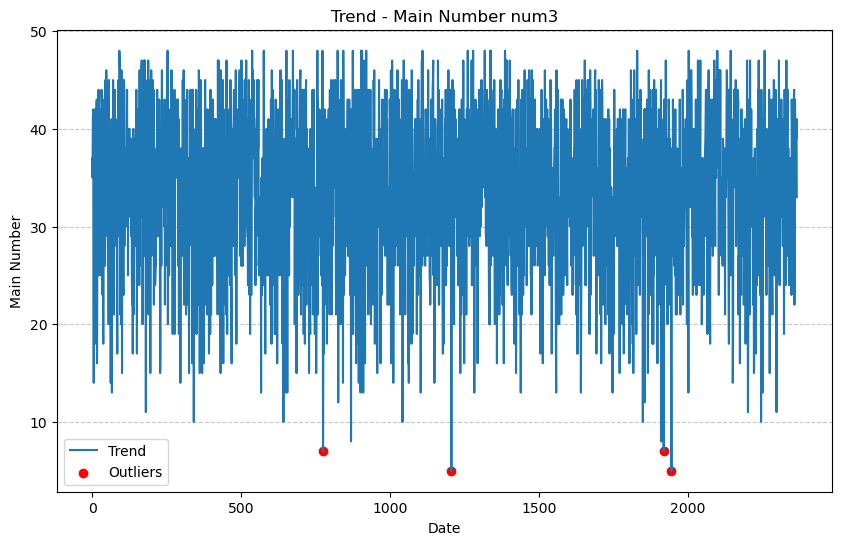

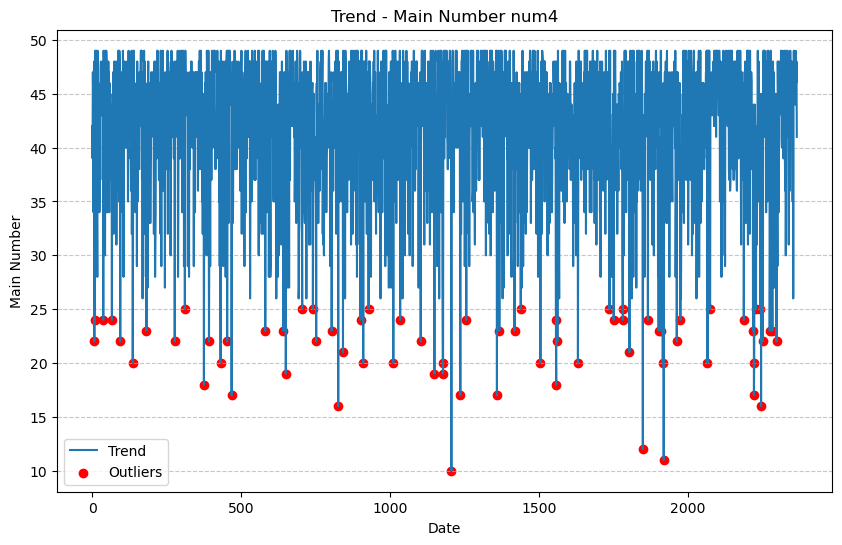

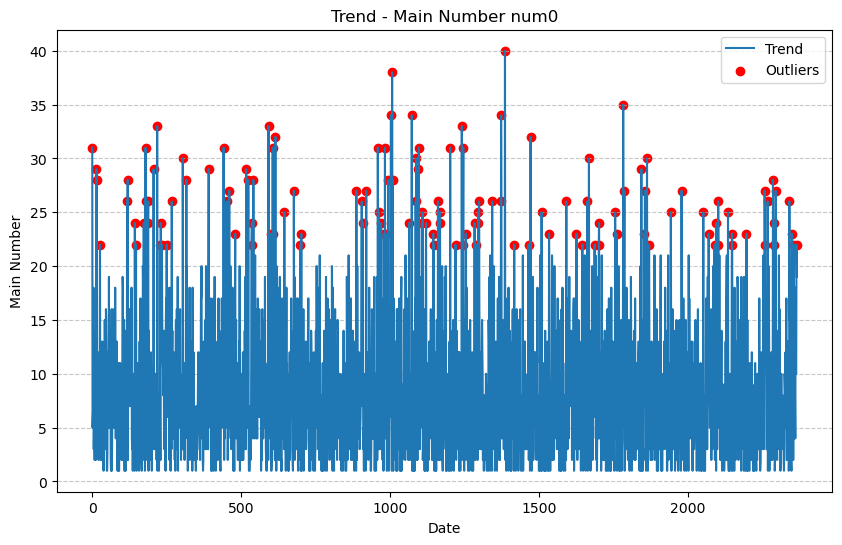

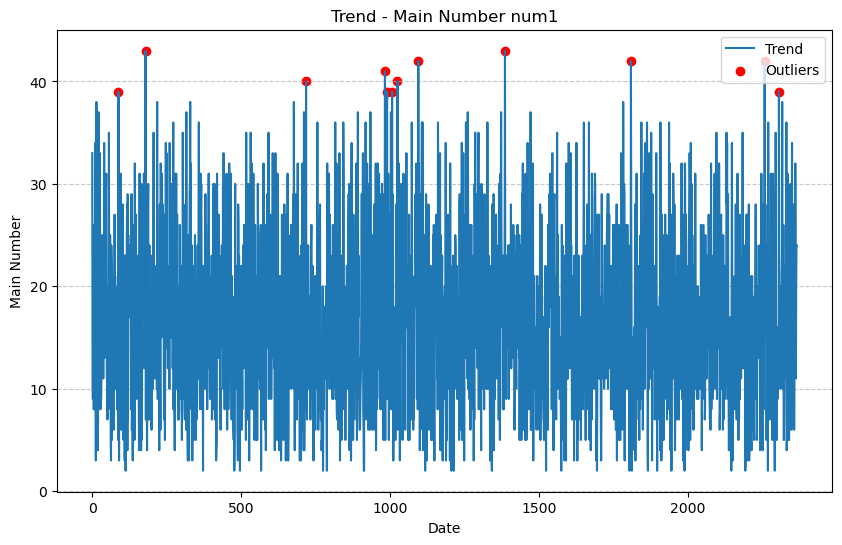

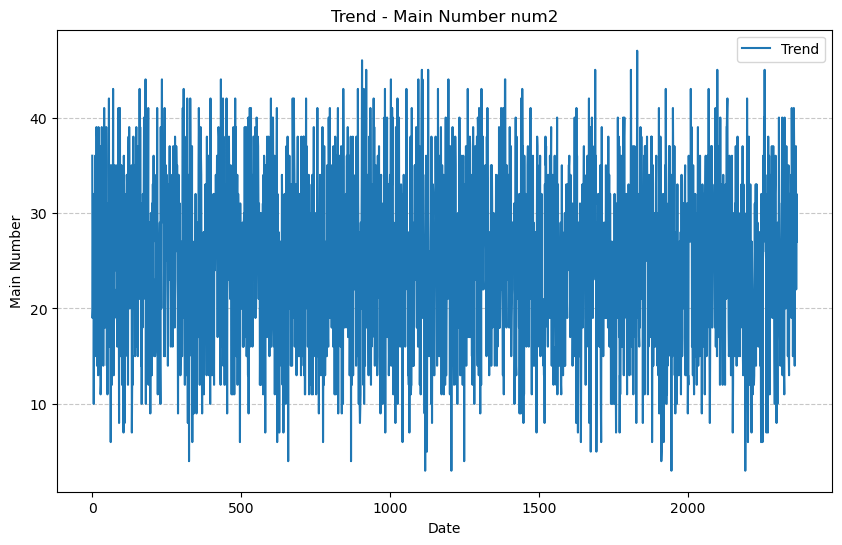

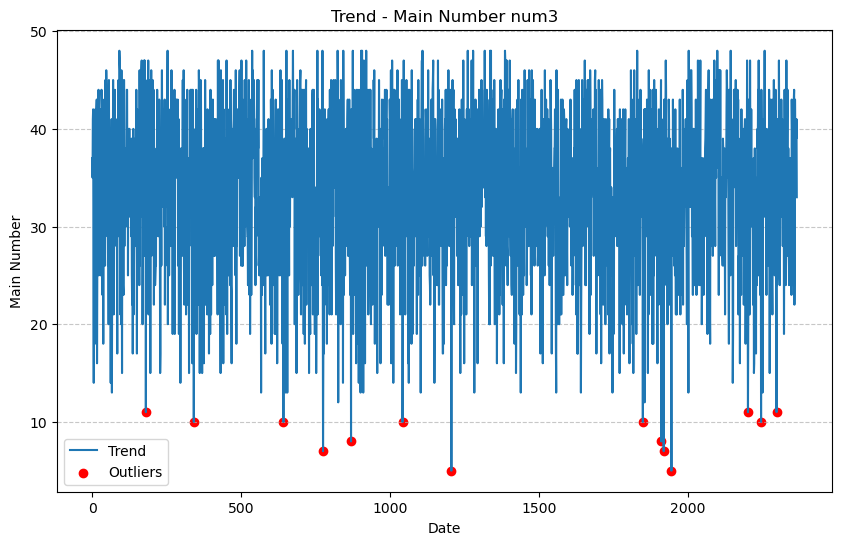

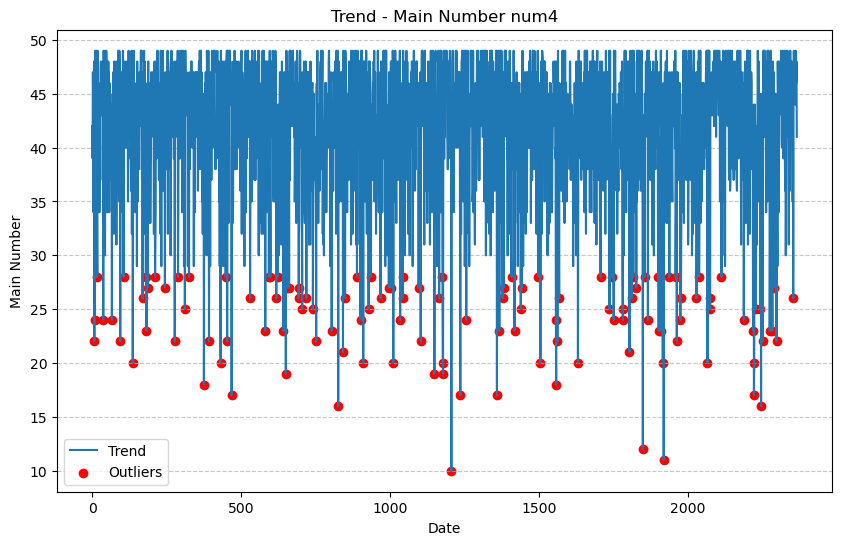

In [15]:
# Detect and visualize outliers in the trend data for each main number
threshold_for_outliers = 3  # Set the threshold for outlier detection (you can adjust this based on your data)
plot_main_number_trends_with_outliers(historical_data, threshold_for_outliers)

threshold_value = 2.5
plot_main_number_trends_with_outliers(historical_data, threshold_value)

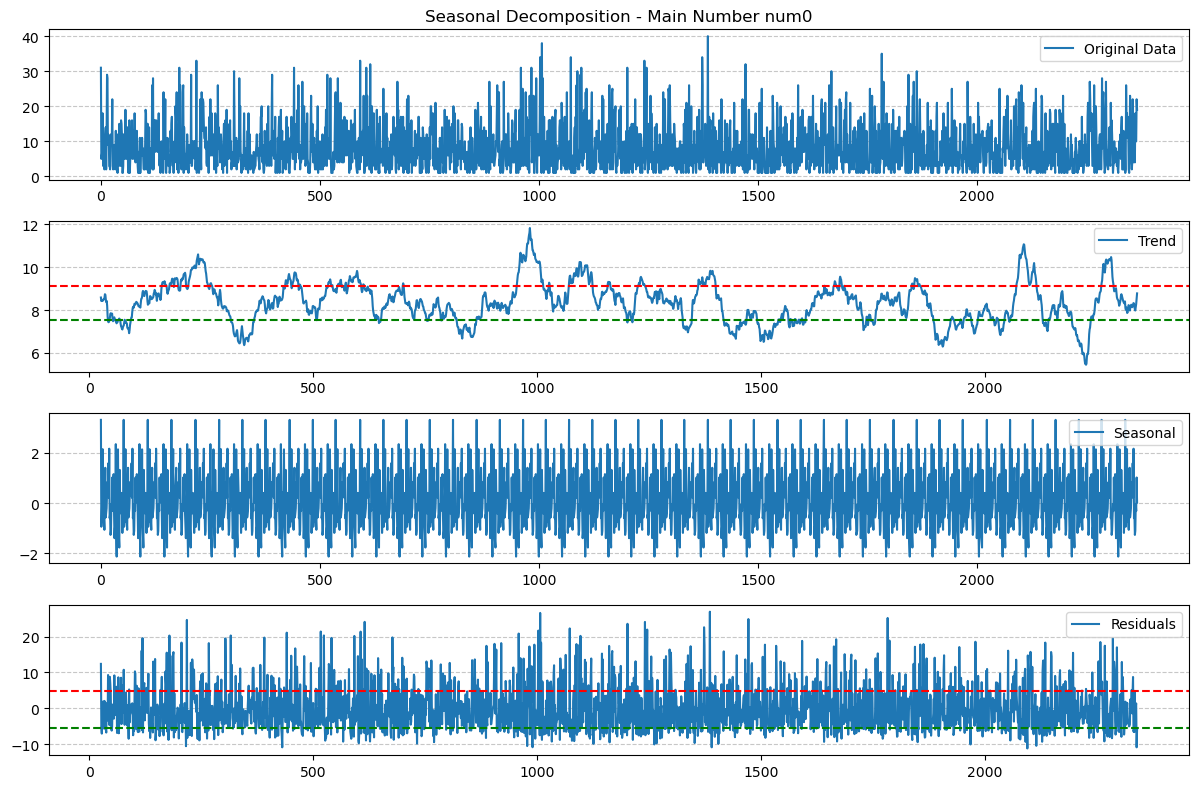

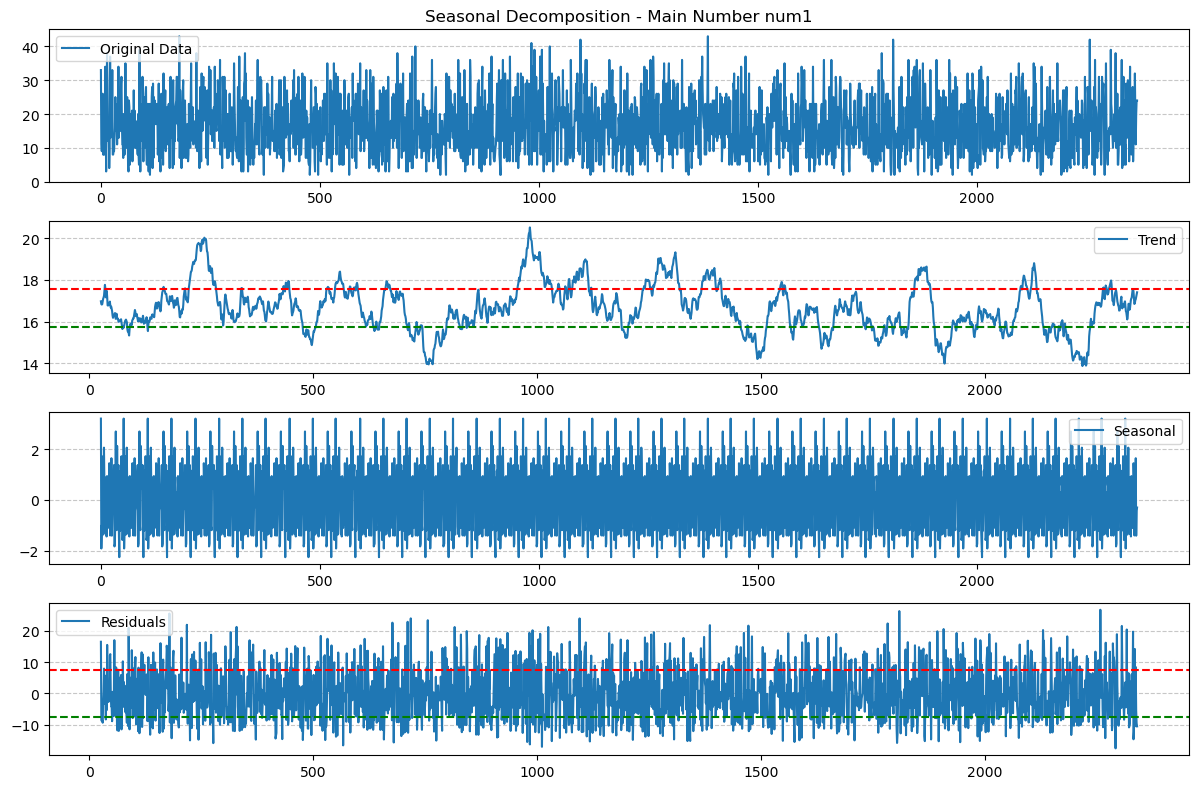

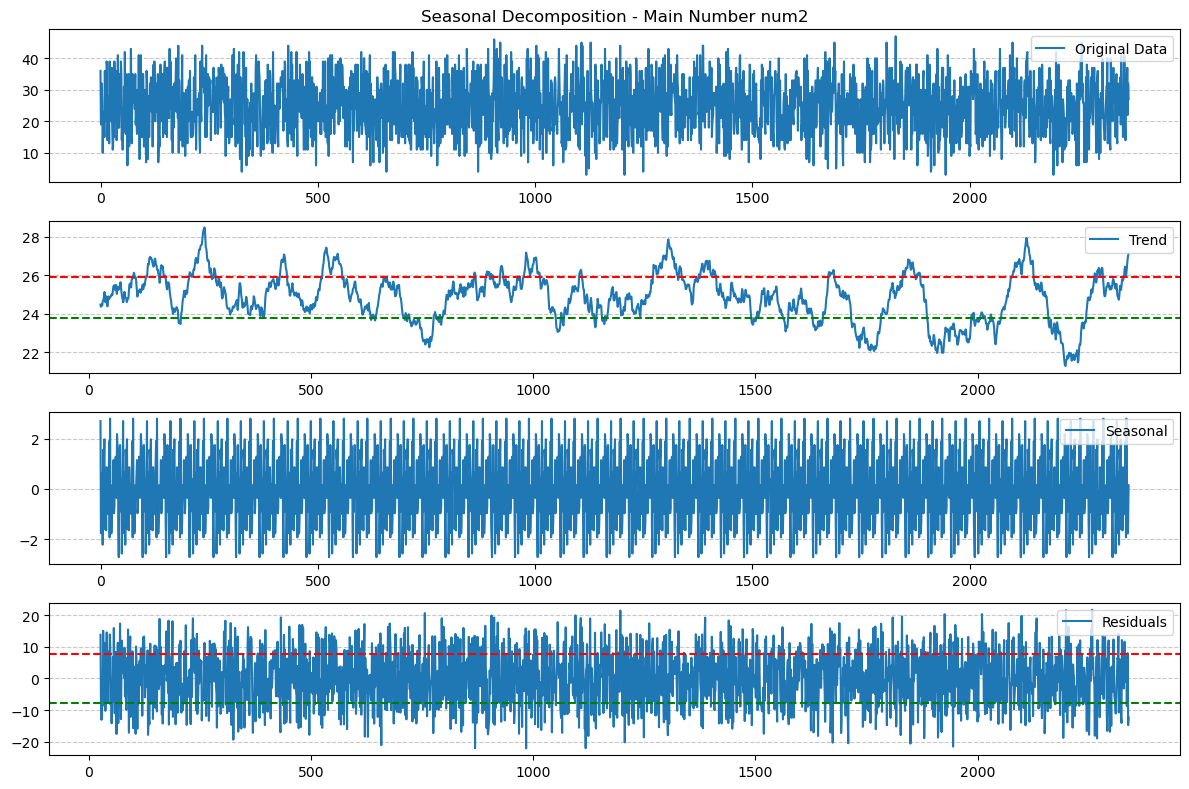

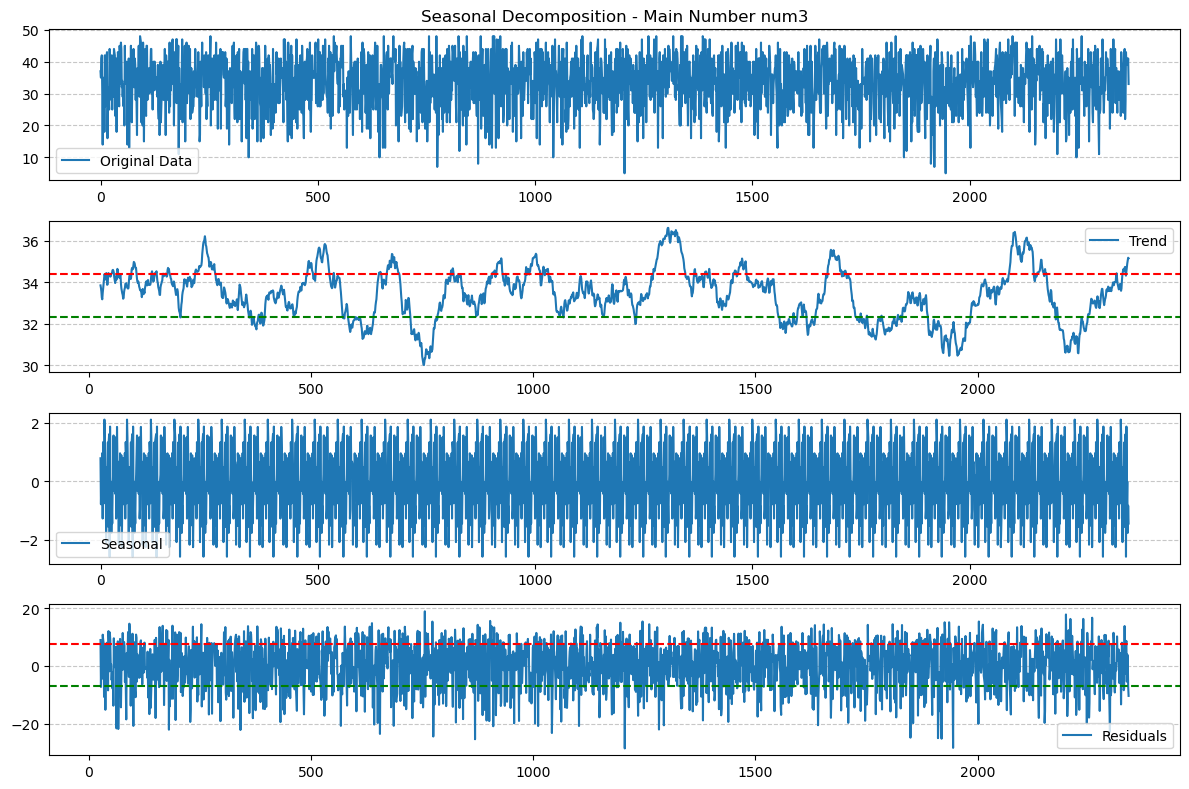

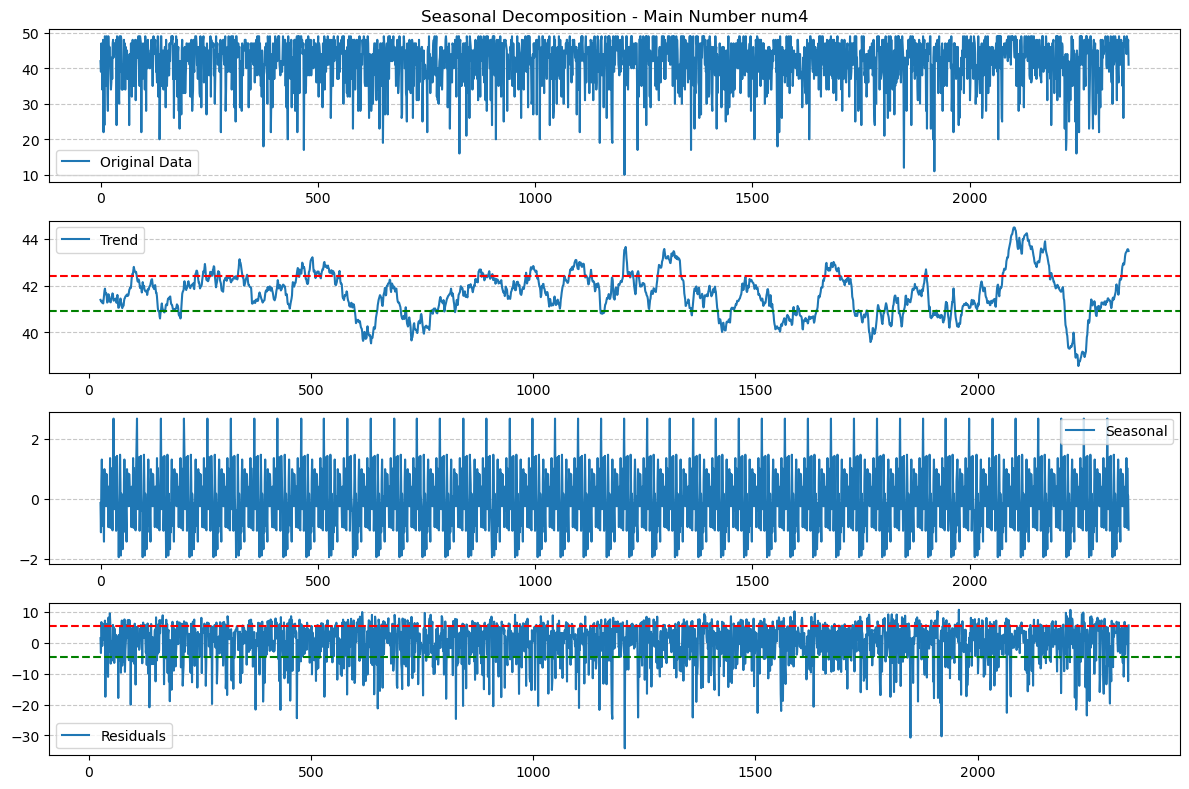

In [16]:
# Data Visualization: Seasonal Decomposition for Each Main Number
seasonality_period = 52  # Assuming seasonality occurs every 52 weeks (weekly data)
seasonal_decomposition_for_each_main_number(historical_data, seasonality_period)

In [17]:
outlier_counts = count_outliers(historical_data.iloc[:, :-1], threshold_value)
print("Total number of outliers for each column:")
print(outlier_counts)

Total number of outliers for each column:
{'num0': 129, 'num1': 12, 'num2': 0, 'num3': 14, 'num4': 123}


In [18]:
historical_data

,num0,num1,num2,num3,num4,chance
2366,19,24,27,33,41,9
2365,22,24,32,41,48,1
2364,10,20,22,39,46,4
2363,10,11,37,41,48,4
2362,18,20,28,40,49,1
...,...,...,...,...,...,...
4,18,26,27,31,34,8
3,7,12,32,42,45,6
2,6,9,20,41,47,9
1,5,11,19,35,39,9


In [19]:
# Feature Engineering: Add new columns to historical_data DataFrame
historical_data = moving_averages(historical_data)
historical_data = lagged_features(historical_data)
historical_data = frequency_count(historical_data)
historical_data = statistical_measures(historical_data)
historical_data = number_pair_frequency(historical_data)
historical_data = recent_winning_numbers(historical_data)
historical_data = digit_sum(historical_data)
historical_data = number_range(historical_data)
historical_data = consecutive_numbers(historical_data)
historical_data = number_differences(historical_data)
historical_data = odd_even_numbers(historical_data)
historical_data = prime_numbers(historical_data)
historical_data = number_sums_products(historical_data)
historical_data

,num0,num1,num2,num3,num4,chance,MovingAvg_3,MovingAvg_5,MovingAvg_7,Lagged_1,...,Prime_19,Prime_23,Prime_29,Prime_31,Prime_37,Prime_41,Prime_43,Prime_47,NumberSum,NumberProduct
2366,19,24,27,33,41,9,NaN,NaN,NaN,NaN,...,True,False,False,False,False,True,False,False,153,149923224
2365,22,24,32,41,48,1,NaN,NaN,NaN,9.0,...,False,False,False,False,False,True,False,False,168,33251328
2364,10,20,22,39,46,4,4.666667,NaN,NaN,1.0,...,False,False,False,False,False,False,False,False,141,31574400
2363,10,11,37,41,48,4,3.000000,NaN,NaN,4.0,...,False,False,False,False,True,True,False,False,151,32039040
2362,18,20,28,40,49,1,3.000000,3.8,NaN,4.0,...,False,False,False,False,False,False,False,False,156,19756800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,18,26,27,31,34,8,5.000000,5.4,6.714286,2.0,...,False,False,False,True,False,False,False,False,144,106546752
3,7,12,32,42,45,6,5.333333,5.2,6.142857,8.0,...,False,False,False,False,False,False,False,False,144,30481920
2,6,9,20,41,47,9,7.666667,6.0,6.000000,6.0,...,False,False,False,False,False,True,False,True,132,18730440
1,5,11,19,35,39,9,8.000000,6.8,6.285714,9.0,...,True,False,False,False,False,False,False,False,118,12837825


# IMPUTATION OF NAN VALUES BY MEAN VALUE

In [20]:
# IMPUTION OF NAN VALUES 
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Create an imputer object with the desired strategy (e.g., mean, median)
imputer = SimpleImputer(strategy='median')

# Fit and transform the data to fill missing values
X = historical_data
X_imputed = imputer.fit_transform(X)

# Convert the array back to a DataFrame with column names
historical_data = pd.DataFrame(X_imputed, columns=X.columns)
historical_data


,num0,num1,num2,num3,num4,chance,MovingAvg_3,MovingAvg_5,MovingAvg_7,Lagged_1,...,Prime_19,Prime_23,Prime_29,Prime_31,Prime_37,Prime_41,Prime_43,Prime_47,NumberSum,NumberProduct
0,19.0,24.0,27.0,33.0,41.0,9.0,5.666667,5.6,5.571429,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,153.0,149923224.0
1,22.0,24.0,32.0,41.0,48.0,1.0,5.666667,5.6,5.571429,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,168.0,33251328.0
2,10.0,20.0,22.0,39.0,46.0,4.0,4.666667,5.6,5.571429,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.0,31574400.0
3,10.0,11.0,37.0,41.0,48.0,4.0,3.000000,5.6,5.571429,4.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,151.0,32039040.0
4,18.0,20.0,28.0,40.0,49.0,1.0,3.000000,3.8,5.571429,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156.0,19756800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2311,18.0,26.0,27.0,31.0,34.0,8.0,5.000000,5.4,6.714286,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,144.0,106546752.0
2312,7.0,12.0,32.0,42.0,45.0,6.0,5.333333,5.2,6.142857,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144.0,30481920.0
2313,6.0,9.0,20.0,41.0,47.0,9.0,7.666667,6.0,6.000000,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,132.0,18730440.0
2314,5.0,11.0,19.0,35.0,39.0,9.0,8.000000,6.8,6.285714,9.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.0,12837825.0


# Feature Importance Analysis

## FOR CHANCE NUMBER

In [21]:
# from sklearn.ensemble import RandomForestRegressor

# # Step 1: Data Preparation
# X = historical_data.drop(columns=['chance'])
# y = historical_data['chance']

# # Step 2: Model Training
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X, y)

# # Step 3: Feature Importance Analysis
# feature_importances = rf_model.feature_importances_

# # Create a DataFrame to show feature importance
# feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# # Sort features by importance (descending order)
# feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# # Set a threshold value for feature importance (e.g., 0.01)
# threshold = 0.01

# # Remove features with importance below the threshold
# selected_features = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature']

# # # Plot feature importances
# # plt.figure(figsize=(10, 6))
# # sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
# # plt.xlabel('Feature Importance')
# # plt.ylabel('Feature')
# # plt.title('Feature Importance from Random Forest')
# # plt.show()

## FOR MAIN NUMBERS

In [22]:
# # Step 1: Data Preparation
# X = historical_data.drop(columns=['num0', 'num1', 'num2', 'num3', 'num4'])
# y_num0 = historical_data['num0']
# y_num1 = historical_data['num1']
# y_num2 = historical_data['num2']
# y_num3 = historical_data['num3']
# y_num4 = historical_data['num4']

# # Step 2: Model Training for each main number
# rf_model_num0 = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model_num0.fit(X, y_num0)

# rf_model_num1 = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model_num1.fit(X, y_num1)

# rf_model_num2 = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model_num2.fit(X, y_num2)

# rf_model_num3 = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model_num3.fit(X, y_num3)

# rf_model_num4 = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model_num4.fit(X, y_num4)

# # Step 3: Feature Importance Analysis for each main number
# feature_importances_num0 = rf_model_num0.feature_importances_
# feature_importances_num1 = rf_model_num1.feature_importances_
# feature_importances_num2 = rf_model_num2.feature_importances_
# feature_importances_num3 = rf_model_num3.feature_importances_
# feature_importances_num4 = rf_model_num4.feature_importances_

# # Create DataFrames to show feature importance for each main number
# feature_importance_df_num0 = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_num0})
# feature_importance_df_num1 = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_num1})
# feature_importance_df_num2 = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_num2})
# feature_importance_df_num3 = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_num3})
# feature_importance_df_num4 = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances_num4})

# # Sort features by importance (descending order)
# feature_importance_df_num0 = feature_importance_df_num0.sort_values(by='Importance', ascending=False)
# feature_importance_df_num1 = feature_importance_df_num1.sort_values(by='Importance', ascending=False)
# feature_importance_df_num2 = feature_importance_df_num2.sort_values(by='Importance', ascending=False)
# feature_importance_df_num3 = feature_importance_df_num3.sort_values(by='Importance', ascending=False)
# feature_importance_df_num4 = feature_importance_df_num4.sort_values(by='Importance', ascending=False)

# # Set a threshold value for feature importance (e.g., 0.01)
# threshold = 0.01

# # Remove features with importance below the threshold for each main number
# selected_features_num0 = feature_importance_df_num0[feature_importance_df_num0['Importance'] >= threshold]['Feature']
# selected_features_num1 = feature_importance_df_num1[feature_importance_df_num1['Importance'] >= threshold]['Feature']
# selected_features_num2 = feature_importance_df_num2[feature_importance_df_num2['Importance'] >= threshold]['Feature']
# selected_features_num3 = feature_importance_df_num3[feature_importance_df_num3['Importance'] >= threshold]['Feature']
# selected_features_num4 = feature_importance_df_num4[feature_importance_df_num4['Importance'] >= threshold]['Feature']


In [23]:
# # Filter columns in historical_data to keep only the selected features for each Main Number and general features
# selected_features_all = selected_features_all = set(['num0', 'num1', 'num2', 'num3', 'num4', 'chance']).union(selected_features_num0,
#                                                                                         selected_features_num1,
#                                                                                         selected_features_num2,
#                                                                                         selected_features_num3,
#                                                                                         selected_features_num4,
#                                                                                         selected_features)
# historical_data_selected = historical_data[selected_features_all]
# # Reorder columns in historical_data_selected to start with num0 to num4 and chance
# column_order = ['num0', 'num1', 'num2', 'num3', 'num4', 'chance'] + list(selected_features_all - set(['num0', 'num1', 'num2', 'num3', 'num4', 'chance']))
# historical_data_selected = historical_data_selected[column_order]
# historical_data_selected_copy = historical_data_selected

In [24]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# DEEP LEARNING LSTM

In [25]:
# from sklearn.preprocessing import MinMaxScaler
# from keras.models import Sequential
# from keras.layers import LSTM, Dense

# LSTM_EPOCH = 10


# # Step 1: Prepare the data
# X = historical_data_selected_copy.drop(columns=['num0', 'num1', 'num2', 'num3', 'num4', 'chance']).values
# y = historical_data_selected_copy[['num0', 'num1', 'num2', 'num3', 'num4', 'chance']].values

# # Step 2: Normalize the data
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)
# y_scaled = scaler.fit_transform(y)

# # Step 3: Reshape the data
# rowToUse = 3 # Eg. 1 correspond to the last row, 2 correspond to the second to last row...
# X_train = X_scaled[:-rowToUse]  # Use all but the last row as the training data
# y_train = y_scaled[:-rowToUse]  # Use all but the last row as the training labels
# X_test = X_scaled[-rowToUse:]   # Use the last row as the testing data

# # Reshape the data to be 3D: (samples, time steps, features)
# X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
# X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# # Step 4: Build the LSTM model
# model_LSTM = Sequential()
# model_LSTM.add(LSTM(LSTM_EPOCH, input_shape=(X_train.shape[1], X_train.shape[2])))
# model_LSTM.add(Dense(6))  # 6 outputs for the 6 main numbers and chance number
# model_LSTM.compile(loss='mean_squared_error', optimizer='adam')

# # Step 5: Train the LSTM model
# model_LSTM.fit(X_train, y_train, epochs=LSTM_EPOCH, batch_size=1, verbose=2)

# # Step 6: Make predictions
# predicted_values_scaled = model_LSTM.predict(X_test)

# # Step 7 : Inverse transform the scaled predictions to get the original scale
# predicted_values = scaler.inverse_transform(predicted_values_scaled)

# # Round the predicted values
# rounded_predicted_values = np.round(predicted_values)

# # Print the rounded predicted values for the next lottery tirage
# print("Predicted Main Numbers and Chance Number:", rounded_predicted_values)


Samedi	    22 juillet 2023		31	33	36	37	42	3
Mercredi	19 juillet 2023		5	11	19	35	39	9
Lundi	    17 juillet 2023		6	9	20	41	47	9
Samedi	    15 juillet 2023		7	12	32	42	45	6
Mercredi	12 juillet 2023		18	26	27	31	34	8

In [26]:
df = historical_data

# Dans cette partie, trois modèles sont disponibles : define_model() pour du LSTM classique, 
# define_bidirectionnel_model() pour du bi-directionnel et define_autoencoder_model()
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow as tf


# Commentaire : window_length = 12 correspond à un apprentissage sur 1 mois de données 

# 1. Paramètress du modèle
nb_label_feature=6 # Pour les 5 numéros et numéro chance
number_of_features = df.shape[1]


# 2. Architecture du modèle
def define_bimodel(number_of_features,nb_label_feature):
    # Initialising the RNN
    model = Sequential()
    # Adding the input layer and the LSTM layer
    model.add(Bidirectional(LSTM(50,
                            input_shape = (window_length, number_of_features),
                            return_sequences = True)))
    # Adding a first Dropout layer
    model.add(Dropout(0.2))
    # Adding a second LSTM layer
    model.add(Bidirectional(LSTM(50,
                            input_shape = (window_length, number_of_features),
                            return_sequences = True)))
    # Adding a second Dropout layer
    model.add(Dropout(0.2))
    # Adding a third LSTM layer
    model.add(Bidirectional(LSTM(50,
                            input_shape = (window_length, number_of_features),
                            return_sequences = True)))
    # Adding a fourth LSTM layer
    model.add(Bidirectional(LSTM(50,
                            input_shape = (window_length, number_of_features),
                            return_sequences = False)))
    # Adding a fourth Dropout layer
    model.add(Dropout(0.2))
    # Adding the first output layer
    model.add(Dense(number_of_features))
    # Adding the last output layer
    model.add(Dense(number_of_features))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_model(number_of_features,nb_label_feature):
    #initialisation du rnn
    model = Sequential()
    #ajout de la premiere couche lstm
    model.add(LSTM(UNITS, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(UNITS, dropout=0.2, return_sequences=False))
    #ajout de la couche de sortie
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_bidirectionnel_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(Bidirectional(LSTM(240, dropout=0.2, return_sequences=True), input_shape=(window_length, number_of_features)))
    model.add(LSTM(120, return_sequences=True))
    model.add(LSTM(240, dropout=0.1))
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model

def define_autoencoder_model(number_of_features,nb_label_feature):
    model = Sequential()
    model.add(LSTM(100, input_shape=(window_length, number_of_features), return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(RepeatVector(window_length))
    model.add(LSTM(100, dropout=0.1, return_sequences=True))
    model.add(LSTM(50, return_sequences=True))
    model.add(TimeDistributed(Dense(number_of_features)))
    model.add(Flatten())
    model.add(Dense(nb_label_feature))
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['acc'])
    return model


# Define a learning rate scheduler function
def learning_rate_scheduler(epoch, lr):
    if epoch < 50:
        return lr  # Keep the initial learning rate for the first 50 epochs
    else:
        return lr * tf.math.exp(-0.1)  # Reduce the learning rate by a factor of ~0.9048 after 50 epochs

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

# Define EarlyStopping callback
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=40)


In [27]:
# Fonction de formatage des données en entrée du LSTM
def create_lstm_dataset(df, window_length,nb_label_feature):
    number_of_rows = df.shape[0]   #taille du dataset number_of_features
    number_of_features = df.shape[1]
    scaler = StandardScaler().fit(df.values)
    transformed_dataset = scaler.transform(df.values)
    transformed_df = pd.DataFrame(data=transformed_dataset, index=df.index)
    
    #tableau de tableau de taille(number_of_rows-window_length) et window_length ligne,number_of_features
    #lstm:[nb total de row ,nb de ligne dans le passé, nb de colonne(feature)]
    train = np.empty([number_of_rows-window_length, window_length, number_of_features], dtype=float)
    
    label = np.empty([number_of_rows-window_length, nb_label_feature], dtype=float)
    for i in range(0, number_of_rows-window_length):
        train[i] = transformed_df.iloc[i:i+window_length, 0: number_of_features]
        label[i] = transformed_df.iloc[i+window_length: i+window_length+1, 0:nb_label_feature]
        
    #définition du modèle Lstm  
    model = define_model(number_of_features,nb_label_feature) #define_model
        
    return train, label, model,scaler

In [28]:
UNITS = 100 #100 #480
BATCHSIZE = 30 #30
EPOCH = 1000 #1500
OPTIMIZER ='adam' # rmsprop, adam, sgd
LOSS = 'mae'#'categorical_crossentropy' #mse
window_length = 2 #12 #18 seems good


# Choix de la date pour la prédiction à effectuer
# --> Mettre en commentaire cette ligne si on veut prédire la date retirée du dataset
# --> Sinon, NE PAS METTRE en commentaire si on veut prédire le prochain tirage. 
b_removeLastTirage=True
if b_removeLastTirage==True:
    df.drop(index=df.index[-1], axis=0, inplace=True)
df


#formatage des données
train, label,model,scaler1 = create_lstm_dataset(df, window_length,nb_label_feature)
print(train.shape)
print(label.shape)



#Training
history=model.fit(train, label, batch_size=BATCHSIZE, epochs=EPOCH, verbose=2,callbacks=[lr_scheduler, es]) # callbacks=[es]

,num0,num1,num2,num3,num4,chance,MovingAvg_3,MovingAvg_5,MovingAvg_7,Lagged_1,...,Prime_19,Prime_23,Prime_29,Prime_31,Prime_37,Prime_41,Prime_43,Prime_47,NumberSum,NumberProduct
0,19.0,24.0,27.0,33.0,41.0,9.0,5.666667,5.6,5.571429,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,153.0,149923224.0
1,22.0,24.0,32.0,41.0,48.0,1.0,5.666667,5.6,5.571429,9.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,168.0,33251328.0
2,10.0,20.0,22.0,39.0,46.0,4.0,4.666667,5.6,5.571429,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,141.0,31574400.0
3,10.0,11.0,37.0,41.0,48.0,4.0,3.000000,5.6,5.571429,4.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,151.0,32039040.0
4,18.0,20.0,28.0,40.0,49.0,1.0,3.000000,3.8,5.571429,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156.0,19756800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2310,3.0,8.0,10.0,14.0,44.0,2.0,4.000000,5.8,6.000000,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,295680.0
2311,18.0,26.0,27.0,31.0,34.0,8.0,5.000000,5.4,6.714286,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,144.0,106546752.0
2312,7.0,12.0,32.0,42.0,45.0,6.0,5.333333,5.2,6.142857,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144.0,30481920.0
2313,6.0,9.0,20.0,41.0,47.0,9.0,7.666667,6.0,6.000000,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,132.0,18730440.0


(2313, 2, 1463)
(2313, 6)
Epoch 1/1000
78/78 - 4s - loss: 0.7963 - acc: 0.1768 - lr: 0.0010 - 4s/epoch - 48ms/step
Epoch 2/1000
78/78 - 1s - loss: 0.6484 - acc: 0.3173 - lr: 0.0010 - 586ms/epoch - 8ms/step
Epoch 3/1000
78/78 - 1s - loss: 0.5046 - acc: 0.4375 - lr: 0.0010 - 534ms/epoch - 7ms/step
Epoch 4/1000
78/78 - 0s - loss: 0.4258 - acc: 0.4998 - lr: 0.0010 - 441ms/epoch - 6ms/step
Epoch 5/1000
78/78 - 0s - loss: 0.3692 - acc: 0.5672 - lr: 0.0010 - 335ms/epoch - 4ms/step
Epoch 6/1000
78/78 - 0s - loss: 0.3320 - acc: 0.6178 - lr: 0.0010 - 344ms/epoch - 4ms/step
Epoch 7/1000
78/78 - 0s - loss: 0.3021 - acc: 0.6619 - lr: 0.0010 - 336ms/epoch - 4ms/step
Epoch 8/1000
78/78 - 0s - loss: 0.2777 - acc: 0.6922 - lr: 0.0010 - 370ms/epoch - 5ms/step
Epoch 9/1000
78/78 - 0s - loss: 0.2606 - acc: 0.7177 - lr: 0.0010 - 333ms/epoch - 4ms/step
Epoch 10/1000
78/78 - 0s - loss: 0.2453 - acc: 0.7328 - lr: 0.0010 - 333ms/epoch - 4ms/step
Epoch 11/1000
78/78 - 0s - loss: 0.2313 - acc: 0.7661 - lr: 0.001

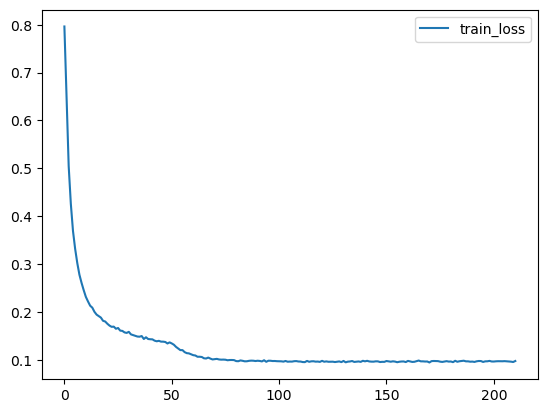

In [29]:
plt.plot(history.history['loss'])
plt.legend(['train_loss'])
plt.show()

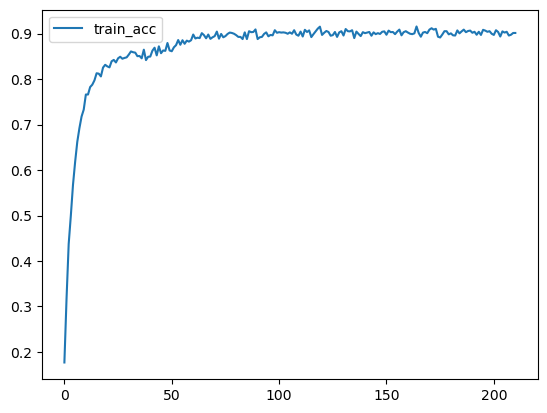

In [30]:
plt.plot(history.history['acc'])
plt.legend(['train_acc'])
plt.show()

In [31]:
#Prediction basée sur les 12 derniers tirages
last_twelve = df.tail(window_length) # on recupere les 12 derniers tirages
scaler = StandardScaler().fit(df.values)
scaled_to_predict = scaler.transform(last_twelve)
scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))

#prediction using scaled_to_predict
tom = df.tail(window_length).iloc[:,0:6] # 
scaler = StandardScaler().fit(df.iloc[:,0:6])
scaled_to_predict = scaler.transform(tom)
pred = scaler.inverse_transform(scaled_predicted_output_1)
print(pred.astype(int)[0])

1/1 [==============================] - 1s 803ms/step
[ 6 21 29 37 44  4]


In [32]:
#Prediction basée sur les 12 derniers tirages
last_twelve = df.tail(window_length) # on recupere les 12 derniers tirages
scaler = StandardScaler().fit(df.values)
scaled_to_predict = scaler.transform(last_twelve)
scaled_predicted_output_1 = model.predict(np.array([scaled_to_predict]))

#prediction using scaled_to_predict
tom = df.tail(window_length).iloc[:,0:6] # 
scaler = StandardScaler().fit(df.iloc[:,0:6])
scaled_to_predict = scaler.transform(tom)
pred = scaler.inverse_transform(scaled_predicted_output_1)
print(pred.astype(int)[0])

1/1 [==============================] - 0s 20ms/step
[ 6 21 29 37 44  4]


In [33]:
last_twelve

,num0,num1,num2,num3,num4,chance,MovingAvg_3,MovingAvg_5,MovingAvg_7,Lagged_1,...,Prime_19,Prime_23,Prime_29,Prime_31,Prime_37,Prime_41,Prime_43,Prime_47,NumberSum,NumberProduct
2313,6.0,9.0,20.0,41.0,47.0,9.0,7.666667,6.0,6.000000,6.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,132.0,18730440.0
2314,5.0,11.0,19.0,35.0,39.0,9.0,8.000000,6.8,6.285714,9.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.0,12837825.0
